In [2]:
import pandas as pd
import os
import matplotlib as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
import seaborn as sns
from joblib import load, dump
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
import gc
gc.collect()
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
# sklearn tools for model training and assesment
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.model_selection import GridSearchCV

In [4]:
random_state = 42
np.random.seed(random_state)


In [5]:
os.chdir("/Users/dsg281/Downloads/Grab_safety/safety/safety/Meged_Data/")

In [6]:
#safety_meta_data = pd.read_excel("Train_data.xlsx",index_col=False,nrows =1000)

safety_meta_data = pd.read_excel("Train_data.xlsx",index_col=False)

In [7]:
## Addtinal features from EDA_v2.ipynb

In [8]:
safety = safety_meta_data.copy()

In [9]:
safety['Distance'] = safety['Speed'] * safety['second']
safety['Acceleration'] = np.sqrt(np.power(safety['acceleration_x'], 2) + np.power(safety['acceleration_y'], 2) + np.power(safety['acceleration_z'], 2))
safety["Pitch"] = 180*np.arctan2(safety["acceleration_y"], np.sqrt(safety["acceleration_x"]**2+safety["acceleration_z"]**2))/np.pi
safety['Magnitude'] = np.sqrt(np.power(safety['gyro_x'], 2) + np.power(safety['gyro_y'], 2) + np.power(safety['gyro_z'], 2))

In [10]:
safety['Bearing_ID_diff'] = safety.groupby(['bookingID'])['Bearing'].transform(lambda x: x.diff())


In [11]:
safety['Bearing_ID_diff'] = safety['Bearing_ID_diff'].fillna(method='backfill')


In [12]:
gc.collect()

2097217

## Model - 1 (Train,Validation,Test)

In [13]:
train_set = safety.copy()

In [14]:
train_set.columns

Index(['bookingID', 'Accuracy', 'Bearing', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'Speed',
       'label', 'Distance', 'Acceleration', 'Pitch', 'Magnitude',
       'Bearing_ID_diff'],
      dtype='object')

In [15]:
train_set, test_set = train_test_split(train_set,stratify=train_set['label'])

In [16]:
print("Train shape",train_set.shape )
print("Test shape",test_set.shape )

Train shape (786431, 17)
Test shape (262144, 17)


In [17]:
print("Train Columns Names", train_set.columns)

Train Columns Names Index(['bookingID', 'Accuracy', 'Bearing', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'Speed',
       'label', 'Distance', 'Acceleration', 'Pitch', 'Magnitude',
       'Bearing_ID_diff'],
      dtype='object')


In [18]:
train_set.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label,Distance,Acceleration,Pitch,Magnitude,Bearing_ID_diff
579795,764504178773,3.000,4.000000,-2.238579,10.415975,-0.220267,0.304003,0.561226,-0.362096,146,1.976533,1,288.573862,10.656092,77.813792,0.733830,-49.000000
888427,532575944722,3.486,312.000000,0.428438,10.216557,-0.204264,0.008308,-0.039514,-0.008343,249,0.927154,1,230.861346,10.227576,87.340074,0.041231,150.000000
47981,231928234160,10.000,222.031219,-0.500946,-8.446399,-3.792834,0.005105,-0.031778,0.032062,716,16.469999,0,11792.519508,9.272443,-65.631981,0.045430,15.147293
829491,1666447310947,10.000,50.754250,0.602780,-9.416589,-2.888589,-0.005155,0.051066,0.006152,259,0.000000,0,0.000000,9.868103,-72.600931,0.051693,-64.333771
588048,738734374954,3.000,286.000000,-0.785322,7.733508,5.231491,0.032987,-0.014661,-0.051313,353,0.608600,1,214.835835,9.369758,55.625918,0.062738,196.000000


In [19]:
target = train_set['label']
del train_set['label']

In [20]:
# Creating splits
shuffle_split_tr = ShuffleSplit(n_splits=10, test_size=0.3, random_state=22)
shuffle_split_tr.get_n_splits(train_set, target)
train_idx, val_idx = next(shuffle_split_tr.split(train_set, target))

In [21]:
print("train_idx shape",train_idx.shape )
print("val_idx shape",val_idx.shape )

train_idx shape (550501,)
val_idx shape (235930,)


In [22]:
#From train_set -> val set

In [23]:
shuffle_split_val_test = ShuffleSplit(n_splits=1, test_size=0.5, random_state=22)
shuffle_split_val_test.get_n_splits(val_idx, target[val_idx])
val_idx, tst_idx = next(shuffle_split_val_test.split(val_idx, target[val_idx])) 


In [24]:
print("val_idx shape",val_idx.shape )
print("tst_idx shape",tst_idx.shape )

val_idx shape (117965,)
tst_idx shape (117965,)


## Model Preparation Light Gradient Boosting Machine

In [25]:
train_lgb = lgb.Dataset(train_set.iloc[train_idx],
                        label=target.iloc[train_idx])

In [26]:
val_lgb = lgb.Dataset(train_set.iloc[val_idx],
                      label=target.iloc[val_idx])

In [27]:
params_1 = {'num_leaves': 60,
          'min_data_in_leaf': 60, 
          'objective':'binary',
          'max_depth': 8,
          'learning_rate': 0.1,
          'boosting': 'gbdt',
          'feature_fraction': 0.8,
          'bagging_freq': 1,
          'bagging_fraction': 0.8 ,
          'bagging_seed': 11,
          'metric': 'auc',
          'lambda_l1': 0.50,
          'random_state': 133,
          'verbosity': -1,
         'metric' : 'auc'}


num_round = 4000


In [28]:
model = lgb.train(params_1,
                  train_lgb,
                  num_round,
                  valid_sets = [train_lgb, val_lgb],
                  verbose_eval = 100,
                  early_stopping_rounds = 200)                                                                                                       

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.974405	valid_1's auc: 0.973766
[200]	training's auc: 0.991503	valid_1's auc: 0.991073
[300]	training's auc: 0.995701	valid_1's auc: 0.995377
[400]	training's auc: 0.997356	valid_1's auc: 0.997025
[500]	training's auc: 0.998342	valid_1's auc: 0.998033
[600]	training's auc: 0.998885	valid_1's auc: 0.998596
[700]	training's auc: 0.99921	valid_1's auc: 0.998937
[800]	training's auc: 0.999447	valid_1's auc: 0.999205
[900]	training's auc: 0.999599	valid_1's auc: 0.999375
[1000]	training's auc: 0.999711	valid_1's auc: 0.999508
[1100]	training's auc: 0.999794	valid_1's auc: 0.999607
[1200]	training's auc: 0.999854	valid_1's auc: 0.999675
[1300]	training's auc: 0.999896	valid_1's auc: 0.999736
[1400]	training's auc: 0.999926	valid_1's auc: 0.999777
[1500]	training's auc: 0.99995	valid_1's auc: 0.999813
[1600]	training's auc: 0.999966	valid_1's auc: 0.999841
[1700]	training's auc: 0.999977	valid_1's auc: 0.999

# Predicting probabilities  - Test Data 

In [29]:
test_set.columns

Index(['bookingID', 'Accuracy', 'Bearing', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'Speed',
       'label', 'Distance', 'Acceleration', 'Pitch', 'Magnitude',
       'Bearing_ID_diff'],
      dtype='object')

In [30]:
test_set_with_label = test_set.copy()

In [31]:
test_set = test_set.drop(columns=['label'],axis=1)

In [32]:
test_set.head(1)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,Distance,Acceleration,Pitch,Magnitude,Bearing_ID_diff
207844,1151051235334,3.9,279.0,0.33878,9.718064,2.96043,-0.172677,-0.054367,0.069284,891,21.820105,19441.713555,10.164629,72.953419,0.193838,274.0


In [33]:
# Predicting probabilities 
probs = model.predict(test_set, num_iteration=model.best_iteration)
predictions_lgbm_01 = np.where(probs > 0.5, 1, 0) #Turn probability to 0-1 binary output


In [34]:
test_set['lgbm'] = predictions_lgbm_01

In [35]:
Counter(test_set_with_label['label'])

Counter({1: 88526, 0: 173618})

In [36]:
Counter(test_set['lgbm'])

Counter({1: 88111, 0: 174033})

In [37]:
## Model Importance Finding 

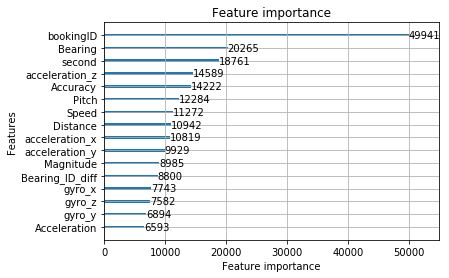

In [38]:
lgb.plot_importance(model,importance_type='split')

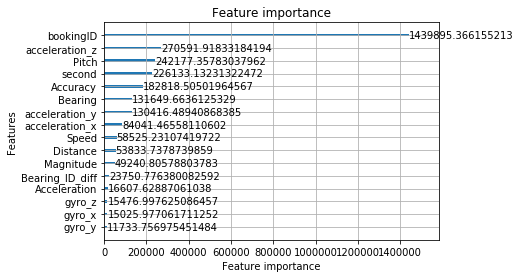

In [39]:
lgb.plot_importance(model,importance_type='gain')

In [40]:
acc_lgbm = accuracy_score(test_set_with_label['label'],predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)


Overall accuracy of Light GBM model: 0.9922676086425781


## Area Under Curve

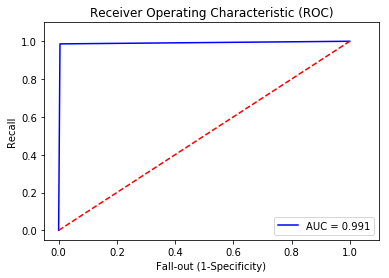

In [46]:
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(test_set_with_label['label'], predictions_lgbm_01)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([-0.05, 1.10])
plt.ylim([-0.05, 1.10])

plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()


In [43]:
AUC = roc_auc_score(test_set_with_label['label'], predictions_lgbm_01)
print("Auc Score", AUC)

Auc Score 0.9907825330454763


## Confusion Matrix

<Figure size 432x288 with 0 Axes>

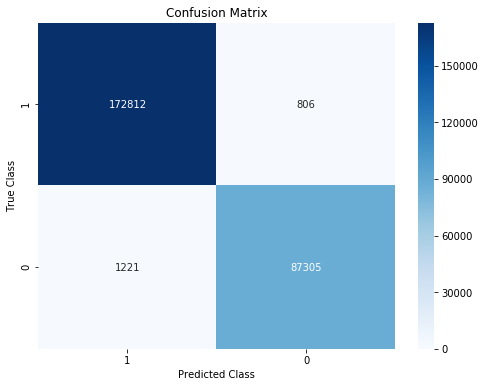

In [48]:
plt.figure()
cm = confusion_matrix(test_set_with_label['label'], predictions_lgbm_01)
labels = ['1', '0']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


In [49]:
target_names = test_set_with_label['label'].unique()


In [50]:
print(classification_report(test_set_with_label['label'], predictions_lgbm_01))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    173618
           1       0.99      0.99      0.99     88526

   micro avg       0.99      0.99      0.99    262144
   macro avg       0.99      0.99      0.99    262144
weighted avg       0.99      0.99      0.99    262144



## Final Report 

In [50]:
print('Accuracy of Light GBM model:', acc_lgbm,'\n')
print("Auc Score", AUC,'\n')
print("Confusion Matrix",classification_report(test_set_with_label['label'], predictions_lgbm_01),'\n')

Accuracy of Light GBM model: 0.9922676086425781 

Auc Score 0.9907825330454763 

Confusion Matrix               precision    recall  f1-score   support

           0       0.99      1.00      0.99    173618
           1       0.99      0.99      0.99     88526

   micro avg       0.99      0.99      0.99    262144
   macro avg       0.99      0.99      0.99    262144
weighted avg       0.99      0.99      0.99    262144
 

